In [1]:
from radiomorpho import *
import skimage.feature # local binary patterns and other possibly useful stuff
import skimage.transform
import warnings; warnings.simplefilter('ignore')
from sklearn import decomposition

from skimage.transform import rotate, rescale

In [2]:
dirs = ('101first_fit', '101nvss_fit')
files, images = readImagesFromDirs(dirs)

error reading image 101first_fit/J0331-2849_z1.0890p_1.09Mpc.fi.fit or 101nvss_fit/J0331-2849_z1.0890p_1.09Mpc.nv.fit


In [3]:
def reshape_images(images, sz):
    return [rescale(im, (sz/im.shape[0], sz/im.shape[1]), mode='reflect') for im in images]

In [79]:
FIRST_imgaes = np.array(reshape_images(images[:,1], 29))

In [80]:
#number of spots, lobes and center, can be 1, 2, 3, or 0 when unknown
num_spots = [2, 2, 3, 2, 1, 2, 3, 0, 3, 3, 2, 2, 3, 2, 2, 0, 2, 2, 2, 1, 0, 2, 2, 2, 1, 2, 0, 3, 2, 3, 3, 2, 2, 2, 3, 2, 2, 3, 3, 2, 2, 2, 3, 3, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 3, 2, 3, 3, 2, 3, 2, 2, 0, 2, 2, 3, 2, 2, 2, 3, 1, 2, 2, 3, 2, 2, 0, 2, 3, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3 ]

In [81]:
FIRST_clean = np.array([ remove_data_bellow_threshold(img) for img in  FIRST_imgaes ])

In [17]:
def get_lbp_hist(img, P=360, R=1):
    lbp = skimage.feature.local_binary_pattern(img, P, R, method='uniform')
    return sk.exposure.histogram(lbp)[0]

In [116]:
# data = []
# for img in FIRST_clean:
#     vec = get_lbp_hist(img, P=360, R = 1.2) 
#     data.append(vec)
# data = np.array(data)

data = []
for img in FIRST_clean:
    vec = np.concatenate( (
        get_lbp_hist(img, P=360, R = 1), 
        get_lbp_hist(img, P=360, R = 4), 
        get_lbp_hist(img, P=360, R = 8),
        get_lbp_hist(img, P=360, R = 16))
    )
    data.append(vec)
data = np.array(data)

[0.88683231 0.05829102]


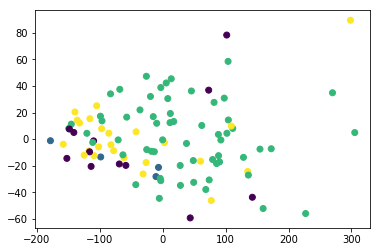

In [117]:
pca = decomposition.PCA(n_components=2)
pca.fit(data)
Y = pca.transform(data)
xs, ys = Y[:,0] , Y[:,1]
print(pca.explained_variance_ratio_)
plt.scatter(Y[: , 0], Y[: , 1], c=num_spots)
plt.show()

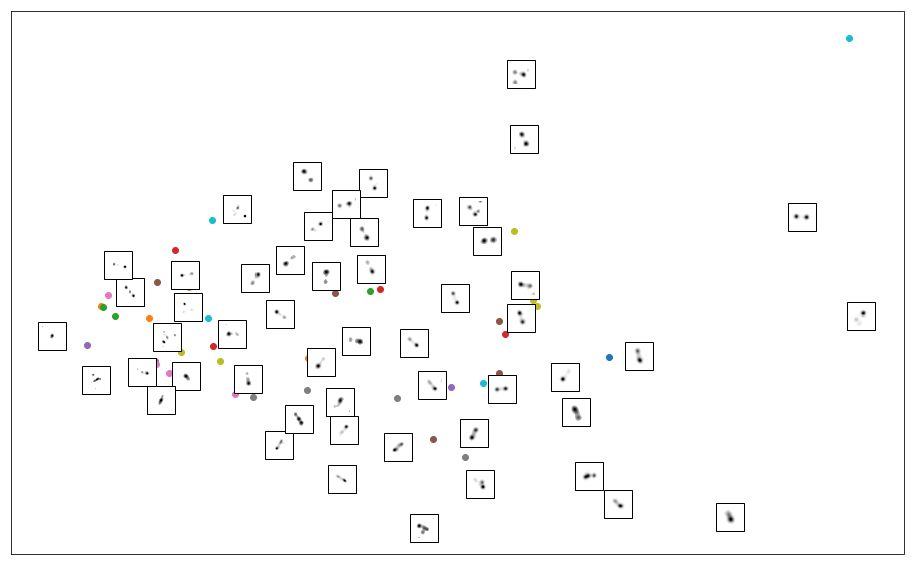

In [118]:
plot_embedding(Y, FIRST_clean , space = 0.003, figsize=(16, 10))

In [49]:
def img_distance(im1, im2):
    dif = im1 - im2
    return np.linalg.norm(dif)

def best_rotate(im1, im2):
    min_dist = img_distance(im1, im2)
    angle = 0
    for i in range(1, 360):
        im_r = rotate(im2, i)
        ndist = img_distance(im1, im_r)
        if(ndist < min_dist):
            min_dist = ndist
            angle = i
    return angle

def best_rotate_flip(im1, im2):
    angle = best_rotate(im1, im2)
    im2_r = rotate(im2, angle)
    min_dist = img_distance(im1, im2_r)
    angle_f = best_rotate(im1, im2[:,::-1])
    im2_rf = rotate(im2[:,::-1], angle)
    min_dist_f = img_distance(im1, im2_rf)
    if(min_dist_f < min_dist): return (angle_f, True)
    return (angle, False)

In [50]:
def procrates_dist(images_r, n_iter = 5):
    avg_img = images_r[0]
    new_avg = np.zeros_like(avg_img)
    for it in range(n_iter):
        for i in range(len(images_r)):
            angle, flip = best_rotate_flip(avg_img, images_r[i])
            images_r[i] = rotate(images_r[i], angle)
            if(flip): images_r[i] = images_r[i][:,::-1]
            new_avg += images_r[i] / len(images_r)
        avg_img = new_avg
    return images_r, avg_img

In [82]:
%%time
images_r = [img for img in FIRST_clean]
images_r, avg_img = procrates_dist(images_r)

CPU times: user 46.6 s, sys: 12.5 ms, total: 46.6 s
Wall time: 46.8 s


In [65]:
dt = [img.reshape(1, avg_img.shape[0] * avg_img.shape[1]) [0] for img in images_r]

In [66]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(dt)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [67]:
pca.explained_variance_ratio_ #very low...

array([0.28212587, 0.2565264 ])

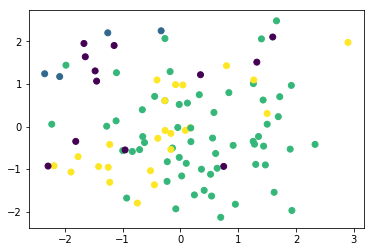

In [68]:
Y = pca.transform(dt)
xs, ys = Y[:,0] , Y[:,1]
plt.scatter(xs, ys, c=num_spots)

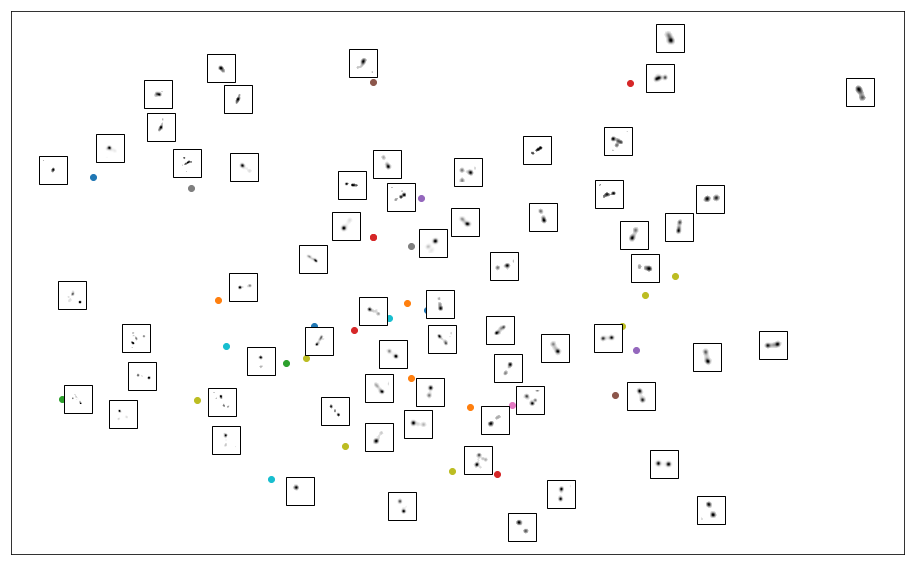

In [83]:
plot_embedding(Y, FIRST_clean , space = 0.003, figsize=(16, 10))

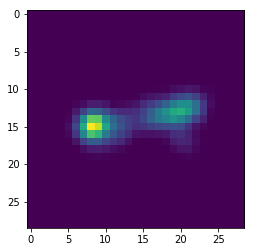

In [71]:
plt.imshow(FIRST_clean[1])

In [85]:
def sphere_elem(rad):
    l      = 2 * rad + 1
    elem   = np.zeros((l , l), dtype='float')
    center = np.array((rad, rad))
    for i in range(l):
        for j in range(l):
            d = np.linalg.norm( center - np.array([i, j]) )
            elem[i, j] = d
    return elem

def erosion_sphere_m(img, r):
    m_img = np.copy(img)
    elem = sphere_elem(r)
    a, b = elem.shape
    l, m = m_img.shape
    scale = img.mean()
    elem *= scale
    for i in range(l):
        for j in range(m):
            h = img[i, j] - elem[r, r]
            for x in range(a):
                i_x = i + (x - r) #x - r gives us absolute pos for -r to r
                if (i_x < 0 or i_x >= l): continue #don't allow negative indexes
                for y in range(b):
                    j_y = j + (y - r) #y - r gives us absolute pos for -r to r
                    if(j_y < 0 or j_y >= m): continue #don't allow negative indexes
                    val = img[i_x, j_y] 
                    if(val < elem[x, y] + h):
                        h = val - elem[x, y]
            n_val = h + elem[r, r]
            m_img[i, j] = n_val if n_val > 0 else 0
    return m_img

def dilation_sphere_m(img, r):
    m_img = np.copy(img)
    elem = sphere_elem(r)
    a, b = elem.shape
    l, m = m_img.shape
    scale = img.mean()
    elem *= scale
    for i in range(l):
        for j in range(m):
            h = img[i, j] - elem[r, r]
            for x in range(a):
                i_x = i + (x - r) #x - r gives us absolute pos for -r to r
                if (i_x < 0 or i_x >= l): continue #don't allow negative indexes
                for y in range(b):
                    j_y = j + (y - r) #y - r gives us absolute pos for -r to r
                    if(j_y < 0 or j_y >= m): continue #don't allow negative indexes
                    val = img[i_x, j_y] 
                    if(val > elem[x, y] + h):
                        h = val - elem[x, y]
            n_val = h + elem[r, r]
            m_img[i, j] = n_val if n_val > 0 else 0
    return m_img


def opening_sphere(img, r):
    return erosion_sphere_m(dilation_sphere_m(img, r), r)
def closing_sphere(img, r):
    return dilation_sphere_m(erosion_sphere_m(img, r), r)

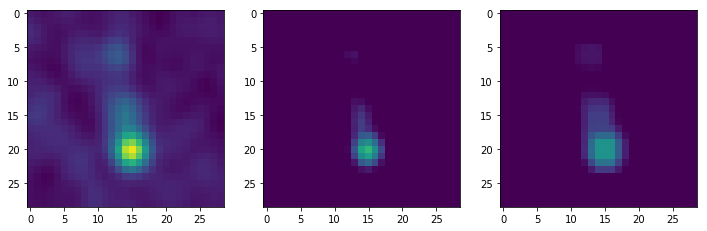

In [97]:
img = FIRST_imgaes[2]
r = 1
f, ax = plt.subplots(1, 3, figsize=(12,15))
ax[0].imshow(img, vmin=0, vmax=1)
e_img = opening_sphere(img, r)
ax[1].imshow(e_img, vmin=0, vmax=1)
e_img = closing_sphere(img, r)
ax[2].imshow(e_img, vmin=0, vmax=1)
plt.show()

In [103]:
def get_open_close_info(im, sz):
    o_area = img_area(im)
    a = np.zeros((2 * sz))
    for i in range(sz):
        im_c = opening_sphere(im, i+1)
        a[i] = (o_area - img_area(im_c)) / o_area
        im_c = closing_sphere(im, i + 1)
        a[i + sz] = (o_area - img_area(im_c)) / o_area
    return a

In [104]:
dt = []
for im in FIRST_clean:
    dt.append( get_open_close_info(im, 3) )
dt = np.array(dt)

In [106]:
dt[:, :3].shape

(100, 3)

In [111]:
dat = dt
pca = decomposition.PCA(n_components=2)
pca.fit(dat)
Y = pca.transform(dat)
xs, ys = Y[:,0] , Y[:,1]
pca.explained_variance_ratio_

array([0.44867956, 0.38065964])

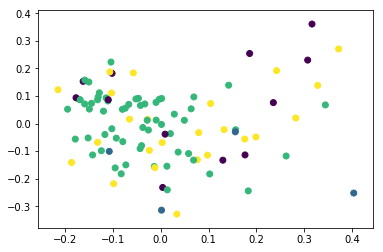

In [112]:
plt.scatter(xs, ys, c=num_spots)

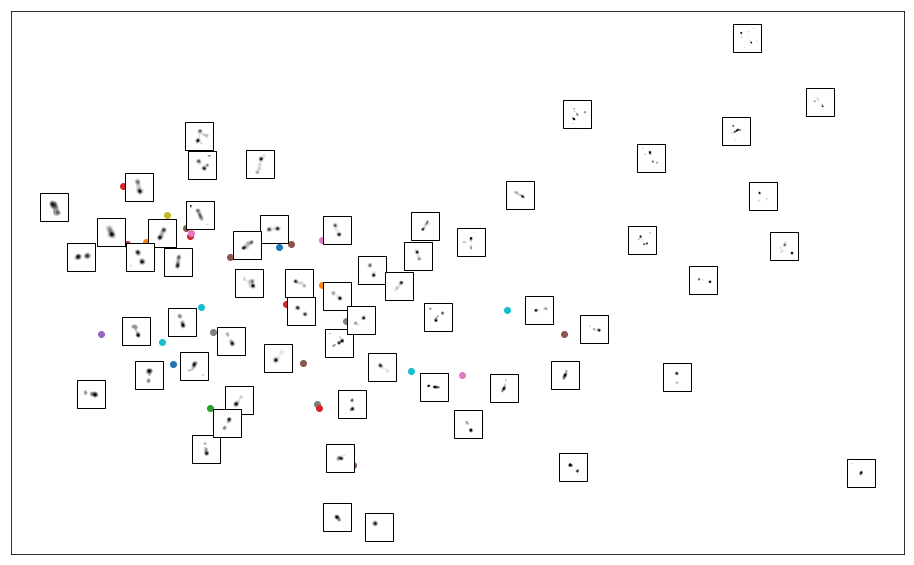

In [114]:
plot_embedding(Y, FIRST_clean , space = 0.002, figsize=(16, 10))